# preliminaries

## import packages

In [13]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

#file system
import os
import glob

#data handling
import numpy as np
import pandas as pd

#plotting
import seaborn as sns 
import matplotlib as mpl
import matplotlib.pyplot as plt

# custom code
from src import features, annotation, parameters, segmentation, spectrogramming


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## load path variables

In [14]:
## TODO: put these is a paths.py file and run it here using %run /path/to/file.py

#paths to raw data
all_wav_raw = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/raw/development/'
all_wav_bw_po_cf = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/raw/bw_po_cf/'
all_wav_bw_po_f1 = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/raw/bw_po_f1/'
all_wav_bw_po_f2 = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/raw/bw_po_f2/'

#paths to clips for developmental dataset
all_voc_clips_dirs = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/clips/amplitude_segmented/final/vocalization_clips'
all_bg_clips_dirs = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/clips/amplitude_segmented/final/background_clips/'

#root directory for all of the segments (start and stop times)
segments_root = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/segments/'
clips_root = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/clips/'
specs_root = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/features/spectrograms/'

#csv of annotated segments (start and stop times) from the development dataset
test_set_path = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/annotated/annotations_csv/all_annotations.csv'

# segment the audio using amplitude thresholding

## set the segmenting parameters

In [17]:
#choose the parameters
thresholds_path = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/noise/all_noise_floors.csv'
seg_params = {
    'min_freq': 20e3, # minimum frequency
    'max_freq': 125e3, # maximum frequency
    'nperseg': 1024, # FFT
    'noverlap': 1024//2, # FFT
    'spec_min_val': .8, # minimum log-spectrogram value
    'spec_max_val': 6, # maximum log-spectrogram value
    'fs': 250000, # audio samplerate
    'th_1':.3, # segmenting threshold 1
    'th_2':.3, # segmenting threshold 2
    'th_3':.35, # segmenting threshold 3
    'min_dur':0.015, # minimum syllable duration
    'max_dur': 1, # maximum syllable duration
    'min_intersyllable': .004,
    'smoothing_timescale': 0.00025, # amplitude
    'softmax': False, # apply softmax to the frequency bins to calculate
                      # amplitude
    'temperature':0.01, # softmax temperature parameter
    'thresholds_path': None,
    'algorithm': '<function get_onsets_offsets at 0x7f944cc355f0>', # (defined above)
}


#name them
dataset = 'development'
iteration = parameters.get_date_time()
params_save_name = ('_').join([dataset,iteration])
params_save_dir = os.path.join(segments_root,dataset,'amplitude_segmented',iteration,'00_params')+'/'

#make directories for them
if iteration not in os.listdir(os.path.join(segments_root,dataset, 'amplitude_segmented')):
    path_to_make = os.path.join(segments_root,dataset,'amplitude_segmented',iteration)
    os.mkdir(path_to_make)
    print('making this directory:\n\t', path_to_make)
    
if '00_params' not in os.listdir(os.path.join(segments_root,dataset,'amplitude_segmented',iteration)):
    path_to_make = os.path.join(segments_root,dataset,'amplitude_segmented',iteration,'00_params')
    os.mkdir(path_to_make)
    print('making this directory:\n\t', path_to_make)

#save them
assert os.path.exists(params_save_dir)
assert params_save_dir.endswith('/')
parameters.save_parameters(params = seg_params, 
                           save_dir = params_save_dir, 
                           save_name = params_save_name)



making this directory:
	 /n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/segments/development/amplitude_segmented/20230118_083823
making this directory:
	 /n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/segments/development/amplitude_segmented/20230118_083823/00_params
making a new params file...
saved the params file to:
 /n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/segments/development/amplitude_segmented/20230118_083823/00_params/development_20230118_083823


## segment

In [20]:
#get raw audio to segment
dataset = dataset
raw_dir = all_wav_raw

#TO DO just remove these from the raw data
#if the dataset is bw_po_f2, ensure that the corrupted unsegmented files aren't in raw_dir
unsegmentable = ['ch8_BWxPO-cross-F2_26878x27490_fam-D3_ltr6_pup4_ch8_4700_f_333_298_fr0_p9_2021-04-16_15-26-07.wav',
                 'ch8_BWxPO-cross-F2_26878x27490_fam-D3_ltr6_pup7_ch8_3800_f_338_285_fr0_p7_2021-04-14_17-27-18.wav',
                 'ch8_BWxPO-cross-F2_27404x27407_fam-A7_ltr1_pup7_ch8_4200_m_328_275_fr1_p7_2021-01-05_13-47-10.wav']

for i in unsegmentable:
    assert i not in os.listdir(raw_dir)

#specify the directory where segment csvs will be saved
save_dir = os.path.join(segments_root,dataset,'amplitude_segmented',iteration)

#load the params and make sure everything looks ok
print('\ndata set is:\n\t',dataset, '\n')

seg_params = parameters.load_parameters(save_dir = params_save_dir, 
                                        save_name = params_save_name)
print('\nthey are:\n')
for key in seg_params.keys():
    print('\t',key,':',seg_params[key])

print('\nstart and stop times will be identified in raw wav files here:\n\t', raw_dir)
print('\nand saved here:\n\t', save_dir)
    
val = input('everything look ok for segmenting? y/n')
assert val in ['y','n']
if val == 'n':
    print('ok - doing nothing')
elif val == 'y':
    segmentation.get_amplitude_segments(audio_dir = raw_dir, 
                                        save_dir = save_dir, 
                                        seg_params = seg_params, 
                                        species = None, 
                                        thresholds_path = seg_params['thresholds_path'],
                                        intersyll_threshold = seg_params['min_intersyllable'], 
                                        duration_threshold = seg_params['min_dur'])




data set is:
	 development 

loaded parameters from:
	 /n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/segments/development/amplitude_segmented/20230118_083823/00_params/development_20230118_083823

they are:

	 min_freq : 20000.0
	 max_freq : 125000.0
	 nperseg : 1024
	 noverlap : 512
	 spec_min_val : 0.8
	 spec_max_val : 6
	 fs : 250000
	 th_1 : 0.3
	 th_2 : 0.3
	 th_3 : 0.35
	 min_dur : 0.015
	 max_dur : 1
	 min_intersyllable : 0.004
	 smoothing_timescale : 0.00025
	 softmax : False
	 temperature : 0.01
	 thresholds_path : None
	 algorithm : <function get_onsets_offsets at 0x7f944cc355f0>

start and stop times will be identified in raw wav files here:
	 /n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/raw/development/

and saved here:
	 /n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/segments/development/amplitude_segmented/20230118_083823
everything look ok for segmenting? y/ny
Segmenting everything...
Segmenting WITHOUT per recording noise floors...
0 recordin

/n/hoekstra_lab_tier1/Users/njourjine/public_repositories/peromyscus-pup-vocal-evolution/src/segmentation.py:100: WavFileWarning: Chunk (non-data) not understood, skipping it.
  _, audio = wavfile.read(file)


SEGMENTING... LL_21614x21466_ltr1_pup2_ch2_3300_f_352_307_fr0_p9_2019-05-19_07-48-32.wav
spec_min_val is 0.8
getting maxima
...merging vocalizations separated by less than 0.004 seconds..
...dropping vocalizations shorter than 0.015 seconds..
...FOUND 2 vocalizations
/n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/raw/development/MU_31872x31875_ltr2_pup5_ch6_3300_m_338_276_fr0_p7_2022-03-15_09-21-30.wav
PROCESSING... /n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/raw/development/MU_31872x31875_ltr2_pup5_ch6_3300_m_338_276_fr0_p7_2022-03-15_09-21-30.wav
SEGMENTING... MU_31872x31875_ltr2_pup5_ch6_3300_m_338_276_fr0_p7_2022-03-15_09-21-30.wav
spec_min_val is 0.8
getting maxima
...merging vocalizations separated by less than 0.004 seconds..
...dropping vocalizations shorter than 0.015 seconds..
...FOUND 334 vocalizations
/n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/raw/development/LO_30126x29799_ltr6_pup2_ch3_1900_f_316_250_fr0_p1_2022-05-12_15-14-16.wav
PROCESSING

SEGMENTING... GO_24811x22715_ltr1_pup3_ch5_4600_f_336_308_fr1_p13_2019-11-15_08-50-04.wav
spec_min_val is 0.8
getting maxima
...merging vocalizations separated by less than 0.004 seconds..
...dropping vocalizations shorter than 0.015 seconds..
...FOUND 1502 vocalizations
/n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/raw/development/BW_29483x28930_ltr1_pup1_ch2_6200_f_289_307_fr0_p13_2021-10-20_08-55-30.wav
PROCESSING... /n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/raw/development/BW_29483x28930_ltr1_pup1_ch2_6200_f_289_307_fr0_p13_2021-10-20_08-55-30.wav
SEGMENTING... BW_29483x28930_ltr1_pup1_ch2_6200_f_289_307_fr0_p13_2021-10-20_08-55-30.wav
spec_min_val is 0.8
getting maxima
...merging vocalizations separated by less than 0.004 seconds..
...dropping vocalizations shorter than 0.015 seconds..
...FOUND 204 vocalizations
/n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/raw/development/GO_22956x23353_ltr4_pup3_ch5_2900_f_361_285_fr0_p3_2019-12-19_09-08-37.wav
PRO

...merging vocalizations separated by less than 0.004 seconds..
...dropping vocalizations shorter than 0.015 seconds..
...FOUND 72 vocalizations
/n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/raw/development/BW_29483x28930_ltr1_pup5_ch6_6500_m_303_289_fr1_p13_2021-10-20_08-55-30.wav
PROCESSING... /n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/raw/development/BW_29483x28930_ltr1_pup5_ch6_6500_m_303_289_fr1_p13_2021-10-20_08-55-30.wav
SEGMENTING... BW_29483x28930_ltr1_pup5_ch6_6500_m_303_289_fr1_p13_2021-10-20_08-55-30.wav
spec_min_val is 0.8
getting maxima
...merging vocalizations separated by less than 0.004 seconds..
...dropping vocalizations shorter than 0.015 seconds..
...FOUND 287 vocalizations
/n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/raw/development/LO_29037x29674_ltr3_pup2_ch3_6400_m_342_327_fr0_p13_2022-01-12_13-01-17.wav
PROCESSING... /n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/raw/development/LO_29037x29674_ltr3_pup2_ch3_6400_m_342_327_

SEGMENTING... BK_30139x30008_ltr3_pup3_ch4_2800_m_342_266_fr0_p3_2022-01-13_09-16-46.wav
spec_min_val is 0.8
getting maxima
...merging vocalizations separated by less than 0.004 seconds..
...dropping vocalizations shorter than 0.015 seconds..
...FOUND 382 vocalizations
/n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/raw/development/MU_31064x31067_ltr3_pup3_ch4_1900_m_337_251_fr0_p5_2021-11-24_11-16-47.wav
PROCESSING... /n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/raw/development/MU_31064x31067_ltr3_pup3_ch4_1900_m_337_251_fr0_p5_2021-11-24_11-16-47.wav
SEGMENTING... MU_31064x31067_ltr3_pup3_ch4_1900_m_337_251_fr0_p5_2021-11-24_11-16-47.wav
spec_min_val is 0.8
getting maxima
...merging vocalizations separated by less than 0.004 seconds..
...dropping vocalizations shorter than 0.015 seconds..
...FOUND 205 vocalizations
/n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/raw/development/NB_26481x26788_ltr2_pup5_ch6_2200_m_312_271_fr0_p3_2021-11-17_09-47-33.wav
PROCESSI

SEGMENTING... MU_31064x31067_ltr2_pup6_ch6_6200_f_338_306_fr0_p13_2021-11-12_09-48-31.wav
spec_min_val is 0.8
getting maxima
...merging vocalizations separated by less than 0.004 seconds..
...dropping vocalizations shorter than 0.015 seconds..
...FOUND 173 vocalizations
/n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/raw/development/BW_29916x29806_ltr1_pup4_ch5_2400_m_341_268_fr0_p3_2022-02-17_11-10-49.wav
PROCESSING... /n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/raw/development/BW_29916x29806_ltr1_pup4_ch5_2400_m_341_268_fr0_p3_2022-02-17_11-10-49.wav
SEGMENTING... BW_29916x29806_ltr1_pup4_ch5_2400_m_341_268_fr0_p3_2022-02-17_11-10-49.wav
spec_min_val is 0.8
getting maxima
...merging vocalizations separated by less than 0.004 seconds..
...dropping vocalizations shorter than 0.015 seconds..
...FOUND 87 vocalizations
/n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/raw/development/MZ_na_na_na_na_na_na_na_na_box30f_p9_pup5_2022-07-13_11-28-36.wav
PROCESSING... /n/

SEGMENTING... LL_24189x24124_ltr3_pup1_ch2_6100_m_331_336_fr0_p11_2020-02-03_08-53-05.wav
spec_min_val is 0.8
getting maxima
...merging vocalizations separated by less than 0.004 seconds..
...dropping vocalizations shorter than 0.015 seconds..
...FOUND 11 vocalizations
/n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/raw/development/BK_30139x30008_ltr1_pup1_ch2_5500_m_350_336_fr0_p9_2021-12-01_10-05-25.wav
PROCESSING... /n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/raw/development/BK_30139x30008_ltr1_pup1_ch2_5500_m_350_336_fr0_p9_2021-12-01_10-05-25.wav
SEGMENTING... BK_30139x30008_ltr1_pup1_ch2_5500_m_350_336_fr0_p9_2021-12-01_10-05-25.wav
spec_min_val is 0.8
getting maxima
...merging vocalizations separated by less than 0.004 seconds..
...dropping vocalizations shorter than 0.015 seconds..
...FOUND 81 vocalizations
/n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/raw/development/MZ_na_na_na_na_na_na_na_na_box40_p3_pup2_2022-07-11_14-59-09.wav
PROCESSING... /n/ho

SEGMENTING... BK_24865x26049_ltr2_pup6_ch7_5100_m_331_317_fr0_p11_2021-11-03_10-08-14.wav
spec_min_val is 0.8
getting maxima
...merging vocalizations separated by less than 0.004 seconds..
...dropping vocalizations shorter than 0.015 seconds..
...FOUND 341 vocalizations
/n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/raw/development/PO_28315x28473_ltr3_pup2_ch3_4400_m_339_326_fr1_p11_2021-11-21_13-02-02.wav
PROCESSING... /n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/raw/development/PO_28315x28473_ltr3_pup2_ch3_4400_m_339_326_fr1_p11_2021-11-21_13-02-02.wav
SEGMENTING... PO_28315x28473_ltr3_pup2_ch3_4400_m_339_326_fr1_p11_2021-11-21_13-02-02.wav
spec_min_val is 0.8
getting maxima
...merging vocalizations separated by less than 0.004 seconds..
...dropping vocalizations shorter than 0.015 seconds..
...FOUND 154 vocalizations
/n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/raw/development/BK_26334x26379_ltr4_pup1_ch2_2100_m_348_276_fr0_p3_2022-01-14_11-27-20.wav
PROC

SEGMENTING... LL_24931x24804_ltr2_pup4_ch6_3400_f_359_310_fr0_p7_2020-02-03_09-26-13.wav
spec_min_val is 0.8
getting maxima
...merging vocalizations separated by less than 0.004 seconds..
...dropping vocalizations shorter than 0.015 seconds..
...FOUND 725 vocalizations
/n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/raw/development/BW_29483x28930_ltr2_pup2_ch3_2600_m_365_287_fr0_p3_2021-11-07_11-05-53.wav
PROCESSING... /n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/raw/development/BW_29483x28930_ltr2_pup2_ch3_2600_m_365_287_fr0_p3_2021-11-07_11-05-53.wav
SEGMENTING... BW_29483x28930_ltr2_pup2_ch3_2600_m_365_287_fr0_p3_2021-11-07_11-05-53.wav
spec_min_val is 0.8
getting maxima
...merging vocalizations separated by less than 0.004 seconds..
...dropping vocalizations shorter than 0.015 seconds..
...FOUND 192 vocalizations
/n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/raw/development/MU_31872x31875_ltr0_pup5_ch5_3400_f_338_285_fr0_p9_2022-05-12_10-30-01.wav
PROCESSI

SEGMENTING... MZ_na_na_na_na_na_na_na_na_box40_p3_pup7_2022-07-11_15-29-18.wav
spec_min_val is 0.8
getting maxima
...merging vocalizations separated by less than 0.004 seconds..
...dropping vocalizations shorter than 0.015 seconds..
...FOUND 1 vocalizations
/n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/raw/development/MU_32600x32606_ltr0_pup5_ch5_1300_f_313_218_fr0_p1_2022-07-22_15-11-17.wav
PROCESSING... /n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/raw/development/MU_32600x32606_ltr0_pup5_ch5_1300_f_313_218_fr0_p1_2022-07-22_15-11-17.wav
SEGMENTING... MU_32600x32606_ltr0_pup5_ch5_1300_f_313_218_fr0_p1_2022-07-22_15-11-17.wav
spec_min_val is 0.8
getting maxima
...merging vocalizations separated by less than 0.004 seconds..
...dropping vocalizations shorter than 0.015 seconds..
...FOUND 11 vocalizations
/n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/raw/development/BK_24224x25894_ltr4_pup1_ch2_1900_m_337_269_fr0_p1_2022-01-16_10-39-22.wav
PROCESSING... /n/hoek

SEGMENTING... MU_31064x31067_ltr2_pup1_ch1_6400_m_345_302_fr0_p13_2021-11-12_09-48-31.wav
spec_min_val is 0.8
getting maxima
...merging vocalizations separated by less than 0.004 seconds..
...dropping vocalizations shorter than 0.015 seconds..
...FOUND 333 vocalizations
/n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/raw/development/PO_28633x28583_ltr1_pup5_ch6_5600_m_327_311_fr0_p13_2021-10-04_17-29-00.wav
PROCESSING... /n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/raw/development/PO_28633x28583_ltr1_pup5_ch6_5600_m_327_311_fr0_p13_2021-10-04_17-29-00.wav
SEGMENTING... PO_28633x28583_ltr1_pup5_ch6_5600_m_327_311_fr0_p13_2021-10-04_17-29-00.wav
spec_min_val is 0.8
getting maxima
...merging vocalizations separated by less than 0.004 seconds..
...dropping vocalizations shorter than 0.015 seconds..
...FOUND 536 vocalizations
/n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/raw/development/IS_30625x27932_ltr1_pup1_ch2_6000_m_354_326_fr1_p5_2022-01-16_12-16-23.wav
PROC

SEGMENTING... BK_26334x26379_ltr2_pup5_ch6_4000_f_341_300_fr0_p9_2021-12-02_08-59-35.wav
spec_min_val is 0.8
getting maxima
...merging vocalizations separated by less than 0.004 seconds..
...dropping vocalizations shorter than 0.015 seconds..
...FOUND 880 vocalizations
/n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/raw/development/NB_28306x26626_ltr1_pup4_ch5_5000_m_334_300_fr0_p11_2021-10-04_10-04-13.wav
PROCESSING... /n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/raw/development/NB_28306x26626_ltr1_pup4_ch5_5000_m_334_300_fr0_p11_2021-10-04_10-04-13.wav
SEGMENTING... NB_28306x26626_ltr1_pup4_ch5_5000_m_334_300_fr0_p11_2021-10-04_10-04-13.wav
spec_min_val is 0.8
getting maxima
...merging vocalizations separated by less than 0.004 seconds..
...dropping vocalizations shorter than 0.015 seconds..
...FOUND 941 vocalizations
/n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/raw/development/BW_28988x28929_ltr2_pup1_ch2_6300_m_310_319_fr0_p13_2021-10-26_10-30-05.wav
PROC

SEGMENTING... NB_26481x26788_ltr1_pup5_ch6_4300_m_333_287_fr0_p9_2021-08-06_12-59-17.wav
spec_min_val is 0.8
getting maxima
...merging vocalizations separated by less than 0.004 seconds..
...dropping vocalizations shorter than 0.015 seconds..
...FOUND 728 vocalizations
/n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/raw/development/SW_29542x30031_ltr1_pup4_ch5_1500_m_352_251_fr0_p1_2022-01-05_10-54-58.wav
PROCESSING... /n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/raw/development/SW_29542x30031_ltr1_pup4_ch5_1500_m_352_251_fr0_p1_2022-01-05_10-54-58.wav
SEGMENTING... SW_29542x30031_ltr1_pup4_ch5_1500_m_352_251_fr0_p1_2022-01-05_10-54-58.wav
spec_min_val is 0.8
getting maxima
...merging vocalizations separated by less than 0.004 seconds..
...dropping vocalizations shorter than 0.015 seconds..
...FOUND 471 vocalizations
/n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/raw/development/PO_29259x29199_ltr3_pup1_ch2_4600_f_322_313_fr0_p11_2021-10-03_14-03-06.wav
PROCESS

SEGMENTING... BK_30139x30008_ltr4_pup4_ch5_2100_m_350_284_fr0_p1_2022-02-04_11-46-47.wav
spec_min_val is 0.8
getting maxima
...merging vocalizations separated by less than 0.004 seconds..
...dropping vocalizations shorter than 0.015 seconds..
...FOUND 292 vocalizations
/n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/raw/development/BK_30139x30008_ltr2_pup5_ch6_6900_f_323_318_fr0_p11_2021-12-28_11-22-43.wav
PROCESSING... /n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/raw/development/BK_30139x30008_ltr2_pup5_ch6_6900_f_323_318_fr0_p11_2021-12-28_11-22-43.wav
SEGMENTING... BK_30139x30008_ltr2_pup5_ch6_6900_f_323_318_fr0_p11_2021-12-28_11-22-43.wav
spec_min_val is 0.8
getting maxima
...merging vocalizations separated by less than 0.004 seconds..
...dropping vocalizations shorter than 0.015 seconds..
...FOUND 109 vocalizations
/n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/raw/development/GO_23883x23804_ltr1_pup3_ch5_4000_f_360_294_fr0_p7_2019-11-04_10-33-06.wav
PROCE

SEGMENTING... MZ_na_na_na_na_na_na_na_na_box20_p3_pup2_2022-07-11_10-20-03.wav
spec_min_val is 0.8
getting maxima
...merging vocalizations separated by less than 0.004 seconds..
...dropping vocalizations shorter than 0.015 seconds..
...FOUND 1 vocalizations
/n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/raw/development/PO_29259x29199_ltr1_pup5_ch6_1900_m_316_242_fr0_p3_2021-06-29_12-15-54.wav
PROCESSING... /n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/raw/development/PO_29259x29199_ltr1_pup5_ch6_1900_m_316_242_fr0_p3_2021-06-29_12-15-54.wav
SEGMENTING... PO_29259x29199_ltr1_pup5_ch6_1900_m_316_242_fr0_p3_2021-06-29_12-15-54.wav
spec_min_val is 0.8
getting maxima
...merging vocalizations separated by less than 0.004 seconds..
...dropping vocalizations shorter than 0.015 seconds..
...FOUND 31 vocalizations
/n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/raw/development/MZ_na_na_na_na_na_na_na_na_box36_p9_pup1_2022-07-11_14-26-51.wav
PROCESSING... /n/hoekstra_lab_t

SEGMENTING... BW_28988x28929_ltr4_pup4_ch5_3000_f_362_291_fr0_p5_2021-12-05_10-36-57.wav
spec_min_val is 0.8
getting maxima
...merging vocalizations separated by less than 0.004 seconds..
...dropping vocalizations shorter than 0.015 seconds..
...FOUND 279 vocalizations
/n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/raw/development/MU_31873x31877_ltr0_pup7_ch7_3100_m_338_269_fr0_p5_2022-06-28_10-36-13.wav
PROCESSING... /n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/raw/development/MU_31873x31877_ltr0_pup7_ch7_3100_m_338_269_fr0_p5_2022-06-28_10-36-13.wav
SEGMENTING... MU_31873x31877_ltr0_pup7_ch7_3100_m_338_269_fr0_p5_2022-06-28_10-36-13.wav
spec_min_val is 0.8
getting maxima
...merging vocalizations separated by less than 0.004 seconds..
...dropping vocalizations shorter than 0.015 seconds..
...FOUND 587 vocalizations
/n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/raw/development/MZ_na_na_na_na_na_na_na_na_box30f_p9_pup4_2022-07-13_11-21-57.wav
PROCESSING... /n/

SEGMENTING... BK_26334x26379_ltr5_pup3_ch4_1700_m_330_267_fr0_p1_2022-02-06_11-57-13.wav
spec_min_val is 0.8
getting maxima
...merging vocalizations separated by less than 0.004 seconds..
...dropping vocalizations shorter than 0.015 seconds..
...FOUND 432 vocalizations
/n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/raw/development/NB_28995x28876_ltr4_pup1_ch2_3600_m_336_282_fr0_p5_2021-11-22_09-12-17.wav
PROCESSING... /n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/raw/development/NB_28995x28876_ltr4_pup1_ch2_3600_m_336_282_fr0_p5_2021-11-22_09-12-17.wav
SEGMENTING... NB_28995x28876_ltr4_pup1_ch2_3600_m_336_282_fr0_p5_2021-11-22_09-12-17.wav
spec_min_val is 0.8
getting maxima
...merging vocalizations separated by less than 0.004 seconds..
...dropping vocalizations shorter than 0.015 seconds..
...FOUND 610 vocalizations
/n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/raw/development/LO_30126x29799_ltr1_pup2_ch3_1700_m_329_251_fr0_p7_2021-11-11_14-28-07.wav
PROCESSI

SEGMENTING... MU_32600x32606_ltr0_pup4_ch4_1400_m_328_223_fr0_p1_2022-07-22_15-11-17.wav
spec_min_val is 0.8
getting maxima
...merging vocalizations separated by less than 0.004 seconds..
...dropping vocalizations shorter than 0.015 seconds..
...FOUND 17 vocalizations
/n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/raw/development/LO_30126x29799_ltr4_pup2_ch3_4900_m_321_317_fr0_p13_2022-02-04_14-11-34.wav
PROCESSING... /n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/raw/development/LO_30126x29799_ltr4_pup2_ch3_4900_m_321_317_fr0_p13_2022-02-04_14-11-34.wav
SEGMENTING... LO_30126x29799_ltr4_pup2_ch3_4900_m_321_317_fr0_p13_2022-02-04_14-11-34.wav
spec_min_val is 0.8
getting maxima
...merging vocalizations separated by less than 0.004 seconds..
...dropping vocalizations shorter than 0.015 seconds..
...FOUND 106 vocalizations
/n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/raw/development/LO_29262x29612_ltr1_pup4_ch5_2400_m_354_281_fr0_p7_2021-11-21_13-30-52.wav
PROCES

...merging vocalizations separated by less than 0.004 seconds..
...dropping vocalizations shorter than 0.015 seconds..
...FOUND 209 vocalizations
/n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/raw/development/BW_29916x29806_ltr0_pup1_ch2_2500_f_355_279_fr0_p3_2022-02-17_11-10-49.wav
PROCESSING... /n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/raw/development/BW_29916x29806_ltr0_pup1_ch2_2500_f_355_279_fr0_p3_2022-02-17_11-10-49.wav
SEGMENTING... BW_29916x29806_ltr0_pup1_ch2_2500_f_355_279_fr0_p3_2022-02-17_11-10-49.wav
spec_min_val is 0.8
getting maxima
...merging vocalizations separated by less than 0.004 seconds..
...dropping vocalizations shorter than 0.015 seconds..
...FOUND 42 vocalizations
/n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/raw/development/SW_31244x31601_ltr0_pup5_ch6_1700_f_334_251_fr0_p1_2022-07-27_13-39-59.wav
PROCESSING... /n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/raw/development/SW_31244x31601_ltr0_pup5_ch6_1700_f_334_251_fr0_

KeyboardInterrupt: 

## aggregate the segments files 

In [26]:
#choose the dataset and segmenting iteration if you want (otherwise will existing values for dataset and iteration 
#- these are the only things you have to change in this cell to process a new dataset 
# dataset = 'bw_po_f2'
# iteration = '20220921_040238'

segments_path = os.path.join(segments_root,dataset,'amplitude_segmented',iteration)

#make a list of the segments files for each pup
pup_segments = [os.path.join(segments_path, i) for i in os.listdir(segments_path) if i.endswith('.csv') and 'all' not in i and not i.startswith('.')]

#combine them
to_combine = []
for temp in pup_segments:
    temp_df = pd.read_csv(temp)
    to_combine.append(temp_df)
    
all_combined = pd.concat(to_combine)

#add species column info and fix up the source_file columns
all_combined['species'] = [i.split('/')[-1].split('_')[0] for i in all_combined['source_file']]
all_combined['source_file'] = [os.path.split(i)[-1] for i in all_combined['source_file']]

#check for na and duplications, make sure source file is formatted correctly, then save
assert all_combined.isna().sum().sum() == 0
assert all_combined.duplicated().sum() == 0
assert set([i.split('_')[0] for i in all_combined['source_file']]) == set(all_combined['species'])
all_combined.to_csv(os.path.join(segments_path, 'all_combined.csv'), index=False)
print('saved a combined file to:\n\t', os.path.join(segments_path, 'all_combined.csv'))

#preview to make sure column names look ok
all_combined.head()


saved a combined file to:
	 /n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/segments/development/amplitude_segmented/20230118_083823/all_combined.csv


,start_seconds,stop_seconds,source_file,duration,species
0,134.447104,134.641664,PO_29372x28799_ltr2_pup3_ch4_2600_m_354_266_fr...,0.194560,PO
1,134.787072,134.877184,PO_29372x28799_ltr2_pup3_ch4_2600_m_354_266_fr...,0.090112,PO
2,134.883328,134.907904,PO_29372x28799_ltr2_pup3_ch4_2600_m_354_266_fr...,0.024576,PO
3,160.905216,160.948224,PO_29372x28799_ltr2_pup3_ch4_2600_m_354_266_fr...,0.043008,PO
4,160.976896,161.050624,PO_29372x28799_ltr2_pup3_ch4_2600_m_354_266_fr...,0.073728,PO


## segment background (non-vocal intervals)

In [2]:
#segment background - useful for finding wav clips that don't have any vocalizations in them
# dataset = 'bw_po_f2'
# iteration = '20220921_040238'

#choose the species and directories where things will be saved
species =['MZ']

#name the columns that will record start and stop time of background in seconds
start_column = 'start_seconds'
stop_column = 'stop_seconds'

#set directories automatically 
raw_wavs_dir = os.path.join(all_wavs_raw, dataset, iteration)
save_dir = os.path.join(save_dir, '01_background_clips')
if not os.path.exists(save_dir):
    os.path.mkdir(save_dir)
    print('made a directory at', save_dir)

#path to the csv made in the previous cell
all_segments_df = os.path.join(segments_path, 'all_combined.csv')


for s in species:
    save_location = save_dir+s+'/'

    #make a directory for the species
    if s not in os.listdir(save_dir):
        print('making a directory to store', s, 'background clips...')
        save_location = save_dir+s+'/'
        os.mkdir(save_location)
        
    segmentation.get_background_clips(raw_wavs_dir=raw_wavs_dir , 
                                      save_location=save_location, 
                                      all_segments_df=all_segments_df,
                                      start_column=start_column, 
                                      stop_column=stop_column, 
                                      label_column = None, 
                                      species = s, 
                                      units = 's')

# generate wav clips from amplitude segmented segments

## make the wav clips

In [47]:
#load the combined segments csv
source_data_path = os.path.join(segments_path, 'all_combined.csv')
source_data = pd.read_csv(source_data_path)

#make it's what you expect and that you cleaned up na and duplications
assert source_data.isna().sum().sum() == 0
assert source_data.duplicated().sum() == 0
assert set(source_data.columns) == set(['start_seconds', 'stop_seconds', 'source_file', 'duration', 'species'])

if dataset == 'bw_po_cf':
    assert set(source_data['species'].unique()) == set(['BW', 'PO', 'CF-BW', 'CF-PO'])
elif dataset == 'bw_po_f1':
    assert set(source_data['species'].unique()) == set(['cross-BW', 'cross-PO', 'BW-PO-cross-F1'])
elif dataset == 'bw_po_f2':
    assert set(source_data['species'].unique()) == set(['ch1', 'ch2', 'ch3', 'ch4', 'ch5', 'ch6', 'ch7', 'ch8'])
    #drop the unsegmentable bw_po_f2
    unsegmentable = ['ch8_BWxPO-cross-F2_26878x27490_fam-D3_ltr6_pup4_ch8_4700_f_333_298_fr0_p9_2021-04-16_15-26-07.wav',
                 'ch8_BWxPO-cross-F2_26878x27490_fam-D3_ltr6_pup7_ch8_3800_f_338_285_fr0_p7_2021-04-14_17-27-18.wav',
                 'ch8_BWxPO-cross-F2_27404x27407_fam-A7_ltr1_pup7_ch8_4200_m_328_275_fr1_p7_2021-01-05_13-47-10.wav']
    source_data = source_data.loc[~source_data['source_file'].isin(unsegmentable)]

#get the path to the raw unsegmented wavs
if dataset == 'bw_po_cf':
    wavs_dir = all_wav_bw_po_cf
elif dataset == 'bw_po_f1':
    wavs_dir = all_wav_bw_po_f1
elif dataset == 'bw_po_f2':
    wavs_dir = all_wav_bw_po_f2
elif dataset == 'development':
    wavs_dir = all_wav_raw
            
bar = '######################################################################################################'
#set the directory for saving and make it TODO - get the data from datetime
save_root = os.path.join(clips_root,'amplitude_segmentation',dataset)
assert os.path.exists(save_root)

print(bar)
print('segmenting wavs from this directory:\n\n',wavs_dir,'\n')
print(bar)
print('using start and stop times from this file:\n\n',source_data_path,'\n')
print(bar)
print('saving them to individual species directories here:\n\n',save_root,'\n')
print(bar)
print('those species are:\n\n',sorted(source_data['species'].unique()),'\n')
print(bar)
print(len(source_data), 'vocalization clips will be written to wav files')

val = input("continue? y/n")
assert val in ['y', 'n']
if val == 'n':
    print('ok - doing nothing.')
elif val == 'y':
#iterate through the species   
    species_list = list(all_combined['species'].unique())                    
    for species in species_list:
        print(species)
        
        save_location = os.path.join(save_root,species)
        start_column = 'start_seconds'
        end_column = 'stop_seconds'

        if species not in os.listdir(save_root):
            print('making a directory to store', species, 'vocalization clips...')
            os.mkdir(save_location)

        get_wav_clips(wavs_dir = wavs_dir, 
                      save_location = save_location, 
                      source_data = source_data, 
                      start_column = start_column, 
                      end_column = end_column,
                      label_column = None,
                      species = species,
                      margin = 0, 
                      units = 's')

######################################################################################################
segmenting wavs from this directory:

 /n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/raw/bw_po_f2/ 

######################################################################################################
using start and stop times from this file:

 /n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/segments/bw_po_f2/amplitude_segmentation/20220921_040238/all_combined.csv 

######################################################################################################
saving them to individual species directories here:

 /n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/clips/amplitude_segmentation/bw_po_f2 

######################################################################################################
those species are:

 ['ch1', 'ch2', 'ch3', 'ch4', 'ch5', 'ch6', 'ch7', 'ch8'] 

#########################################################################

all segments from ch3_BWxPO-cross-F2_28207x28209_fam-D5_ltr1_pup3_ch3_2900_f_363_300_fr0_p7_2020-12-09_13-02-37.wav already processed, skipping...
all segments from ch3_BWxPO-cross-F2_27004x27488_fam-D1_ltr3_pup6_ch3_4400_f_344_326_fr0_p9_2021-02-03_13-28-11.wav already processed, skipping...
all segments from ch3_BWxPO-cross-F2_28978x28979_fam-A10_ltr6_pup1_ch3_6000_m_336_307_fr1_p9_2021-07-01_13-02-04.wav already processed, skipping...
all segments from ch3_BWxPO-cross-F2_26878x27940_fam-D3_ltr3_pup2_ch3_3700_m_353_303_fr0_p7_2021-01-30_15-22-50.wav already processed, skipping...
all segments from ch3_BWxPO-cross-F2_27732x27733_fam-B5_ltr3_pup2_ch3_3700_m_353_299_fr0_p7_2021-03-07_16-26-47.wav already processed, skipping...
all segments from ch3_BWxPO-cross-F2_26879x27489_fam-D2_ltr7_pup3_ch3_3900_f_331_295_fr0_p9_2021-05-29_14-34-37.wav already processed, skipping...
all segments from ch3_BWxPO-cross-F2_28207x28209_fam-D5_ltr3_pup3_ch3_4200_m_350_300_fr0_p9_2021-02-25_13-59-19.wav a

all segments from ch3_BWxPO-cross-F2_27404x27407_fam-A7_ltr5_pup3_ch3_4200_f_338_320_fr0_p9_2021-04-16_14-10-32.wav already processed, skipping...
all segments from ch3_BWxPO-cross-F2_28693x28694_fam-D8_ltr6_pup2_ch3_4300_f_336_307_fr0_p9_2021-06-09_14-58-09.wav already processed, skipping...
all segments from ch3_BWxPO-cross-F2_28693x28694_fam-D8_ltr6_pup2_ch3_3800_f_339_281_fr0_p7_2021-06-07_15-20-44.wav already processed, skipping...
all segments from ch3_BWxPO-cross-F2_29801x29802_fam-D9_ltr1_pup2_ch3_4200_m_346_295_fr0_p7_2021-05-24_15-44-41.wav already processed, skipping...
all segments from ch3_BWxPO-cross-F2_28457x28458_fam-D6_ltr7_pup2_ch3_5000_m_345_308_fr0_p9_2021-06-18_15-15-44.wav already processed, skipping...
all segments from ch3_BWxPO-cross-F2_27405x27406_fam-A6_ltr8_pup1_ch3_4300_m_333_271_fr0_p9_2021-06-24_12-37-40.wav already processed, skipping...
all segments from ch3_BWxPO-cross-F2_26366x26370_fam-A5_ltr7_pup1_ch3_3300_f_349_308_fr0_p9_2021-06-19_12-42-09.wav al

all segments from ch3_BWxPO-cross-F2_28134x28136_fam-A8_ltr4_pup4_ch3_4700_f_340_313_fr0_p9_2021-03-17_17-12-05.wav already processed, skipping...
all segments from ch3_BWxPO-cross-F2_27405x27406_fam-A6_ltr6_pup2_ch3_3100_m_339_277_fr0_p7_2021-04-27_13-27-57.wav already processed, skipping...
all segments from ch3_BWxPO-cross-F2_25704x25707_fam-A1_ltr8_pup2_ch3_3700_m_343_283_fr1_p7_2021-05-28_15-52-38.wav already processed, skipping...
all segments from ch3_BWxPO-cross-F2_27004x27488_fam-D1_ltr3_pup2_ch3_4000_m_355_310_fr0_p7_2021-02-01_14-14-48.wav already processed, skipping...
all segments from ch3_BWxPO-cross-F2_26878x27490_fam-D3_ltr5_pup2_ch3_3000_f_346_299_fr0_p7_2021-03-20_13-11-27.wav already processed, skipping...
all segments from ch3_BWxPO-cross-F2_26878x27490_fam-D3_ltr4_pup3_ch3_3800_m_346_319_fr0_p9_2021-02-26_16-29-55.wav already processed, skipping...
all segments from ch3_BWxPO-cross-F2_27004x27488_fam-D1_ltr2_pup2_ch3_5000_m_335_312_fr0_p9_2021-01-07_19-22-11.wav al

all segments from ch3_BWxPO-cross-F2_26879x27489_fam-D2_ltr5_pup5_ch3_5000_m_344_308_fr1_p9_2021-03-16_19-10-55.wav already processed, skipping...
all segments from ch3_BWxPO-cross-F2_25704x25707_fam-A1_ltr4_pup1_ch3_3800_f_351_321_fr0_p9_2021-02-09_13-07-31.wav already processed, skipping...
all segments from ch3_BWxPO-cross-F2_27732x27733_fam-B5_ltr4_pup1_ch3_3200_f_338_299_fr0_p9_2021-04-05_19-17-05.wav already processed, skipping...
all segments from ch3_BWxPO-cross-F2_27404x27407_fam-A7_ltr3_pup2_ch3_3600_f_358_297_fr0_p7_2021-02-24_13-28-48.wav already processed, skipping...
all segments from ch3_BWxPO-cross-F2_26878x27490_fam-D3_ltr5_pup4_ch3_4200_f_351_324_fr0_p9_2021-03-22_17-35-18.wav already processed, skipping...
all segments from ch3_BWxPO-cross-F2_28978x28979_fam-A10_ltr3_pup2_ch3_3700_f_345_309_fr1_p7_2021-03-16_15-01-31.wav already processed, skipping...
all segments from ch3_BWxPO-cross-F2_27404x27407_fam-A7_ltr2_pup3_ch3_4800_f_331_325_fr1_p9_2021-02-02_13-00-18.wav a

all segments from ch3_BWxPO-cross-F2_27212x27213_fam-B4_ltr1_pup2_ch3_3000_f_330_286_fr0_p7_2021-01-14_12-56-13.wav already processed, skipping...
all segments from ch3_BWxPO-cross-F2_28207x28209_fam-D5_ltr6_pup2_ch3_3900_f_352_302_fr1_p7_2021-05-10_16-35-22.wav already processed, skipping...
all segments from ch3_BWxPO-cross-F2_28693x28694_fam-D8_ltr2_pup2_ch3_4200_f_363_302_fr1_p7_2021-02-14_15-37-28.wav already processed, skipping...
all segments from ch3_BWxPO-cross-F2_28207x28209_fam-D5_ltr4_pup2_ch3_3600_f_358_306_fr0_p7_2021-03-19_14-06-11.wav already processed, skipping...
all segments from ch3_BWxPO-cross-F2_28134x28136_fam-A8_ltr7_pup4_ch3_4900_m_349_300_fr0_p9_2021-06-21_19-28-11.wav already processed, skipping...
done.
ch6
all segments from ch6_BWxPO-cross-F2_26159x26161_fam-A3_ltr7_pup5_ch6_4600_f_336_298_fr0_p9_2021-04-10_13-56-04.wav already processed, skipping...
all segments from ch6_BWxPO-cross-F2_26879x27489_fam-D2_ltr7_pup4_ch6_4000_m_331_294_fr0_p9_2021-05-29_14-34

all segments from ch6_BWxPO-cross-F2_26158x26160_fam-A4_ltr7_pup5_ch6_4200_f_341_304_fr0_p9_2021-05-28_12-46-59.wav already processed, skipping...
all segments from ch6_BWxPO-cross-F2_28134x28136_fam-A8_ltr2_pup5_ch6_4900_f_343_312_fr0_p7_2021-01-26_17-43-59.wav already processed, skipping...
all segments from ch6_BWxPO-cross-F2_28978x28979_fam-A10_ltr2_pup5_ch6_3500_f_352_302_fr0_p7_2021-02-17_13-47-20.wav already processed, skipping...
all segments from ch6_BWxPO-cross-F2_26158x26160_fam-A4_ltr6_pup5_ch6_3700_m_331_312_fr0_p7_2021-05-02_14-26-37.wav already processed, skipping...
all segments from ch6_BWxPO-cross-F2_27005x27489_fam-D2_ltr2_pup5_ch6_4600_m_328_302_fr1_p9_2020-11-18_14-31-06.wav already processed, skipping...
all segments from ch6_BWxPO-cross-F2_26158x26160_fam-A4_ltr7_pup5_ch6_3400_f_327_294_fr1_p7_2021-05-26_14-45-58.wav already processed, skipping...
all segments from ch6_BWxPO-cross-F2_28339x28341_fam-A9_ltr4_pup4_ch6_4800_m_342_298_fr1_p9_2021-03-13_15-07-36.wav a

all segments from ch6_BWxPO-cross-F2_28456x28459_fam-D7_ltr5_pup5_ch6_4300_m_331_280_fr0_p7_2021-05-01_13-53-48.wav already processed, skipping...
all segments from ch6_BWxPO-cross-F2_28339x28341_fam-A9_ltr5_pup5_ch6_3600_f_345_291_fr0_p7_2021-04-05_17-39-14.wav already processed, skipping...
all segments from ch6_BWxPO-cross-F2_26878x27490_fam-D3_ltr7_pup5_ch6_4900_m_339_306_fr0_p9_2021-05-11_13-03-26.wav already processed, skipping...
all segments from ch6_BWxPO-cross-F2_26159x26161_fam-A3_ltr7_pup5_ch6_3800_f_343_271_fr1_p7_2021-04-08_15-42-49.wav already processed, skipping...
done.
ch5
all segments from ch5_BWxPO-cross-F2_26158x26160_fam-A4_ltr5_pup4_ch5_3800_m_348_283_fr0_p7_2021-04-07_14-04-28.wav already processed, skipping...
all segments from ch5_BWxPO-cross-F2_26366x26370_fam-A5_ltr5_pup2_ch5_5200_m_336_290_fr0_p9_2021-04-30_13-31-10.wav already processed, skipping...
all segments from ch5_BWxPO-cross-F2_28456x28459_fam-D7_ltr7_pup5_ch5_4600_f_338_296_fr0_p9_2021-06-25_15-36

all segments from ch5_BWxPO-cross-F2_28207x28209_fam-D5_ltr4_pup2_ch5_4300_f_347_309_fr0_p9_2021-03-21_13-00-32.wav already processed, skipping...
all segments from ch5_BWxPO-cross-F2_26158x26160_fam-A4_ltr6_pup1_ch5_3900_f_337_300_fr1_p9_2021-05-04_13-48-27.wav already processed, skipping...
all segments from ch5_BWxPO-cross-F2_28339x28341_fam-A9_ltr5_pup3_ch5_4700_f_335_314_fr0_p9_2021-04-07_12-36-49.wav already processed, skipping...
all segments from ch5_BWxPO-cross-F2_28134x28136_fam-A8_ltr2_pup1_ch5_5200_f_331_289_fr0_p9_2021-01-28_14-51-13.wav already processed, skipping...
all segments from ch5_BWxPO-cross-F2_28339x28341_fam-A9_ltr3_pup4_ch5_4500_m_350_293_fr0_p7_2021-02-15_17-34-59.wav already processed, skipping...
all segments from ch5_BWxPO-cross-F2_28134x28136_fam-A8_ltr3_pup4_ch5_3800_m_327_299_fr0_p7_2021-02-17_13-17-35.wav already processed, skipping...
all segments from ch5_BWxPO-cross-F2_28456x28459_fam-D7_ltr2_pup5_ch5_4400_f_324_300_fr0_p9_2021-02-12_15-33-06.wav al

all segments from ch5_BWxPO-cross-F2_26366x26370_fam-A5_ltr3_pup2_ch5_3700_f_346_303_fr0_p9_2021-03-13_13-21-15.wav already processed, skipping...
all segments from ch5_BWxPO-cross-F2_28134x28136_fam-A8_ltr7_pup3_ch5_4500_f_338_295_fr0_p9_2021-06-21_19-28-11.wav already processed, skipping...
all segments from ch5_BWxPO-cross-F2_25704x25707_fam-A1_ltr3_pup3_ch5_3000_m_346_283_fr0_p7_2020-09-16_12-47-17.wav already processed, skipping...
all segments from ch5_BWxPO-cross-F2_26879x27489_fam-D2_ltr3_pup6_ch5_4700_m_346_332_fr0_p9_2021-01-26_15-13-55.wav already processed, skipping...
all segments from ch5_BWxPO-cross-F2_27488x27004_fam-D1_ltr1_pup2_ch5_3800_f_337_313_fr0_p9_2020-10-23_14-42-17.wav already processed, skipping...
all segments from ch5_BWxPO-cross-F2_26366x26370_fam-A5_ltr5_pup4_ch5_2000_m_346_271_fr1_p7_2021-04-28_13-55-10.wav already processed, skipping...
all segments from ch5_BWxPO-cross-F2_27405x27406_fam-A6_ltr8_pup4_ch5_2900_f_336_274_fr0_p9_2021-06-24_12-37-40.wav al

all segments from ch5_BWxPO-cross-F2_26879x27489_fam-D2_ltr7_pup4_ch5_3200_m_348_275_fr0_p7_2021-05-27_15-45-23.wav already processed, skipping...
all segments from ch5_BWxPO-cross-F2_27405x27406_fam-A6_ltr7_pup4_ch5_3800_f_338_298_fr0_p9_2021-05-27_14-02-27.wav already processed, skipping...
all segments from ch5_BWxPO-cross-F2_27404x27407_fam-A7_ltr3_pup4_ch5_3600_f_348_296_fr1_p7_2021-02-24_13-28-48.wav already processed, skipping...
all segments from ch5_BWxPO-cross-F2_27004x27488_fam-D1_ltr8_pup4_ch5_3400_f_348_288_fr0_p7_2021-06-30_15-29-54.wav already processed, skipping...
all segments from ch5_BWxPO-cross-F2_26878x27490_fam-D3_ltr8_pup4_ch5_4700_m_346_279_fr0_p7_2021-06-27_13-07-33.wav already processed, skipping...
all segments from ch5_BWxPO-cross-F2_27004x27488_fam-D1_ltr4_pup4_ch5_3700_f_358_300_fr0_p7_2021-02-25_15-15-51.wav already processed, skipping...
all segments from ch5_BWxPO-cross-F2_26878x27490_fam-D3_ltr4_pup1_ch5_4500_m_346_323_fr1_p9_2021-02-26_16-29-55.wav al

all segments from ch4_BWxPO-cross-F2_25704x25707_fam-A1_ltr8_pup1_ch4_4700_m_341_310_fr1_p9_2021-05-30_12-41-11.wav already processed, skipping...
all segments from ch4_BWxPO-cross-F2_27004x27488_fam-D1_ltr5_pup3_ch4_4800_m_346_286_fr0_p7_2021-03-24_14-19-11.wav already processed, skipping...
all segments from ch4_BWxPO-cross-F2_26159x26161_fam-A3_ltr5_pup3_ch4_3500_f_352_306_fr0_p7_2021-02-18_15-57-37.wav already processed, skipping...
all segments from ch4_BWxPO-cross-F2_28339x28341_fam-A9_ltr3_pup1_ch4_3500_m_346_310_fr0_p9_2021-02-17_20-09-28.wav already processed, skipping...
all segments from ch4_BWxPO-cross-F2_28206x28208_fam-D4_ltr4_pup3_ch4_3600_f_342_306_fr0_p9_2021-04-25_13-02-04.wav already processed, skipping...
all segments from ch4_BWxPO-cross-F2_27212x27213_fam-B4_ltr3_pup3_ch4_3200_f_341_286_fr0_p7_2021-03-11_16-19-10.wav already processed, skipping...
all segments from ch4_BWxPO-cross-F2_28206x28208_fam-D4_ltr1_pup2_ch4_3900_f_336_291_fr0_p7_2020-11-10_13-46-07.wav al

all segments from ch4_BWxPO-cross-F2_28134x28136_fam-A8_ltr4_pup3_ch4_5200_m_348_293_fr0_p7_2021-03-15_17-31-53.wav already processed, skipping...
all segments from ch4_BWxPO-cross-F2_26878x27490_fam-D3_ltr8_pup1_ch4_4800_m_328_307_fr0_p9_2021-06-29_13-17-31.wav already processed, skipping...
all segments from ch4_BWxPO-cross-F2_29462x29463_fam-D12_ltr2_pup3_ch4_3900_m_349_292_fr0_p7_2021-05-24_16-14-48.wav already processed, skipping...
all segments from ch4_BWxPO-cross-F2_26366x26370_fam-A5_ltr7_pup3_ch4_3400_f_346_278_fr0_p7_2021-06-17_13-37-01.wav already processed, skipping...
all segments from ch4_BWxPO-cross-F2_28456x28459_fam-D7_ltr5_pup3_ch4_3000_m_343_292_fr0_p7_2021-05-01_13-53-48.wav already processed, skipping...
all segments from ch4_BWxPO-cross-F2_27405x27406_fam-A6_ltr5_pup3_ch4_2700_m_343_289_fr0_p7_2021-03-30_13-41-45.wav already processed, skipping...
all segments from ch4_BWxPO-cross-F2_26366x26370_fam-A5_ltr4_pup3_ch4_2600_f_353_291_fr0_p7_2021-04-04_14-40-31.wav a

all segments from ch4_BWxPO-cross-F2_26158x26160_fam-A4_ltr7_pup1_ch4_3300_m_335_296_fr0_p9_2021-05-28_12-46-59.wav already processed, skipping...
all segments from ch4_BWxPO-cross-F2_26878x27490_fam-D3_ltr3_pup4_ch4_4100_f_339_319_fr0_p9_2021-02-01_17-47-10.wav already processed, skipping...
all segments from ch4_BWxPO-cross-F2_27004x27488_fam-D1_ltr8_pup3_ch4_3300_f_346_292_fr0_p7_2021-06-30_15-29-54.wav already processed, skipping...
all segments from ch4_BWxPO-cross-F2_27404x27407_fam-A7_ltr3_pup3_ch4_3500_m_354_295_fr0_p7_2021-02-24_13-28-48.wav already processed, skipping...
all segments from ch4_BWxPO-cross-F2_26366x26370_fam-A5_ltr8_pup2_ch4_4300_m_328_278_fr0_p9_2021-07-13_13-26-14.wav already processed, skipping...
all segments from ch4_BWxPO-cross-F2_27404x27407_fam-A7_ltr1_pup3_ch4_2500_f_336_276_fr0_p7_2021-01-05_13-47-10.wav already processed, skipping...
all segments from ch4_BWxPO-cross-F2_26879x27489_fam-D2_ltr3_pup3_ch4_3400_m_353_317_fr0_p7_2021-01-24_17-34-10.wav al

all segments from ch4_BWxPO-cross-F2_27212x27213_fam-B4_ltr3_pup2_ch4_4100_m_337_291_fr0_p9_2021-03-13_17-05-00.wav already processed, skipping...
all segments from ch4_BWxPO-cross-F2_26159x26161_fam-A3_ltr2_pup4_ch4_5300_f_337_303_fr0_p9_2020-10-22_13-34-36.wav already processed, skipping...
all segments from ch4_BWxPO-cross-F2_28339x28341_fam-A9_ltr8_pup3_ch4_3100_m_343_275_fr0_p7_2021-06-16_16-06-08.wav already processed, skipping...
all segments from ch4_BWxPO-cross-F2_28134x28136_fam-A8_ltr6_pup3_ch4_5800_m_339_297_fr0_p9_2021-05-29_13-30-08.wav already processed, skipping...
all segments from ch4_BWxPO-cross-F2_27004x27488_fam-D1_ltr2_pup3_ch4_3800_f_333_308_fr0_p9_2021-01-07_19-22-11.wav already processed, skipping...
all segments from ch4_BWxPO-cross-F2_27212x27213_fam-B4_ltr2_pup1_ch4_5000_m_344_316_fr0_p9_2021-02-14_14-23-15.wav already processed, skipping...
all segments from ch4_BWxPO-cross-F2_27489x27005_fam-D2_ltr2_pup4_ch4_4100_m_353_302_fr1_p7_2020-11-16_14-51-53.wav al

all segments from ch2_BWxPO-cross-F2_28134x28136_fam-A8_ltr5_pup1_ch2_2900_m_353_289_fr0_p7_2021-04-10_17-53-20.wav already processed, skipping...
all segments from ch2_BWxPO-cross-F2_27004x27488_fam-D1_ltr6_pup1_ch2_4200_m_342_312_fr0_p7_2021-04-18_13-19-52.wav already processed, skipping...
all segments from ch2_BWxPO-cross-F2_28339x28341_fam-A9_ltr4_pup3_ch2_3900_f_349_306_fr0_p9_2021-03-13_15-07-36.wav already processed, skipping...
all segments from ch2_BWxPO-cross-F2_25704x25707_fam-A1_ltr1_pup1_ch2_4400_m_348_299_fr0_p9_2020-01-19_13-22-00.wav already processed, skipping...
all segments from ch2_BWxPO-cross-F2_27732x27733_fam-B5_ltr4_pup2_ch2_2900_m_354_296_fr0_p9_2021-04-05_19-17-05.wav already processed, skipping...
all segments from ch2_BWxPO-cross-F2_25704x25707_fam-A1_ltr5_pup1_ch2_3500_f_351_296_fr0_p7_2021-03-07_15-57-03.wav already processed, skipping...
all segments from ch2_BWxPO-cross-F2_27404x27407_fam-A7_ltr7_pup2_ch2_5600_m_333_304_fr1_p9_2021-06-28_13-58-58.wav al

all segments from ch2_BWxPO-cross-F2_26158x26160_fam-A4_ltr7_pup4_ch2_4000_f_341_314_fr0_p9_2021-05-28_12-46-59.wav already processed, skipping...
all segments from ch2_BWxPO-cross-F2_26366x26370_fam-A5_ltr7_pup3_ch2_4100_f_344_311_fr1_p9_2021-06-19_12-42-09.wav already processed, skipping...
all segments from ch2_BWxPO-cross-F2_26366x26370_fam-A5_ltr7_pup1_ch2_2700_f_351_274_fr0_p7_2021-06-17_13-37-01.wav already processed, skipping...
all segments from ch2_BWxPO-cross-F2_28206x28208_fam-D4_ltr4_pup1_ch2_2600_f_347_286_fr0_p7_2021-04-23_16-17-43.wav already processed, skipping...
all segments from ch2_BWxPO-cross-F2_29204x28980_fam-A13_ltr1_pup1_ch2_3400_m_345_284_fr0_p7_2021-05-03_17-48-42.wav already processed, skipping...
all segments from ch2_BWxPO-cross-F2_28206x28208_fam-D4_ltr5_pup1_ch2_2800_m_360_288_fr0_p7_2021-05-20_14-41-18.wav already processed, skipping...
all segments from ch2_BWxPO-cross-F2_28207x28209_fam-D5_ltr3_pup2_ch2_4200_f_345_320_fr0_p9_2021-02-25_13-59-19.wav a

all segments from ch2_BWxPO-cross-F2_27405x27406_fam-A6_ltr7_pup3_ch2_4600_m_331_295_fr0_p9_2021-05-27_14-02-27.wav already processed, skipping...
all segments from ch2_BWxPO-cross-F2_27005x27489_fam-D2_ltr2_pup7_ch2_3700_m_336_300_fr0_p9_2020-11-18_14-31-06.wav already processed, skipping...
all segments from ch2_BWxPO-cross-F2_27732x27733_fam-B5_ltr2_pup1_ch2_2700_f_363_309_fr0_p7_2021-02-11_14-33-14.wav already processed, skipping...
all segments from ch2_BWxPO-cross-F2_28206x28208_fam-D4_ltr1_pup1_ch2_3000_f_344_285_fr0_p7_2020-11-10_13-46-07.wav already processed, skipping...
all segments from ch2_BWxPO-cross-F2_28207x28209_fam-D5_ltr4_pup1_ch2_4100_m_356_298_fr0_p7_2021-03-19_14-06-11.wav already processed, skipping...
all segments from ch2_BWxPO-cross-F2_26159x26161_fam-A3_ltr1_pup2_ch2_4100_f_341_308_fr0_p9_2020-03-07_13-52-55.wav already processed, skipping...
all segments from ch2_BWxPO-cross-F2_27212x27213_fam-B4_ltr5_pup1_ch2_4800_f_340_317_fr0_p9_2021-05-09_12-51-39.wav al

all segments from ch2_BWxPO-cross-F2_26159x26161_fam-A3_ltr1_pup1_ch2_3400_f_348_315_fr0_p7_2020-03-05_12-47-28.wav already processed, skipping...
all segments from ch2_BWxPO-cross-F2_28134x28136_fam-A8_ltr7_pup1_ch2_4500_f_341_302_fr0_p9_2021-06-21_19-28-11.wav already processed, skipping...
all segments from ch2_BWxPO-cross-F2_28339x28341_fam-A9_ltr6_pup1_ch2_3900_m_341_302_fr0_p7_2021-04-29_14-55-28.wav already processed, skipping...
all segments from ch2_BWxPO-cross-F2_27405x27406_fam-A6_ltr3_pup2_ch2_5000_f_334_320_fr0_p9_2021-02-04_17-05-52.wav already processed, skipping...
all segments from ch2_BWxPO-cross-F2_27732x27733_fam-B5_ltr3_pup1_ch2_3000_f_354_297_fr0_p7_2021-03-07_16-26-47.wav already processed, skipping...
all segments from ch2_BWxPO-cross-F2_28207x28209_fam-D5_ltr5_pup2_ch2_5100_m_340_303_fr0_p9_2021-04-16_17-12-46.wav already processed, skipping...
all segments from ch2_BWxPO-cross-F2_27004x27488_fam-D1_ltr2_pup1_ch2_4100_m_357_298_fr1_p7_2021-01-05_15-10-51.wav al

all segments from ch2_BWxPO-cross-F2_29462x29463_fam-D12_ltr1_pup1_ch2_4400_f_358_303_fr0_p7_2021-04-30_15-34-54.wav already processed, skipping...
all segments from ch2_BWxPO-cross-F2_28207x28209_fam-D5_ltr7_pup1_ch2_5600_m_341_282_fr0_p7_2021-06-30_16-00-56.wav already processed, skipping...
all segments from ch2_BWxPO-cross-F2_28134x28136_fam-A8_ltr2_pup6_ch2_5600_m_324_292_fr0_p9_2021-01-28_14-51-13.wav already processed, skipping...
all segments from ch2_BWxPO-cross-F2_27405x27406_fam-A6_ltr1_pup2_ch2_3900_f_338_299_fr0_p9_2020-09-05_13-08-11.wav already processed, skipping...
all segments from ch2_BWxPO-cross-F2_28207x28209_fam-D5_ltr5_pup1_ch2_4700_m_358_279_fr0_p7_2021-04-14_18-00-14.wav already processed, skipping...
all segments from ch2_BWxPO-cross-F2_28978x28979_fam-A10_ltr5_pup1_ch2_3300_m_359_282_fr0_p7_2021-05-08_12-54-46.wav already processed, skipping...
all segments from ch2_BWxPO-cross-F2_28316x28134_fam-A8_ltr1_pup3_ch2_4900_f_346_312_fr0_p9_2020-11-13_16-06-24.wav 

all segments from ch7_BWxPO-cross-F2_26366x26370_fam-A5_ltr2_pup4_ch7_4200_f_337_300_fr1_p9_2021-02-15_14-56-40.wav already processed, skipping...
all segments from ch7_BWxPO-cross-F2_26878x27490_fam-D3_ltr6_pup5_ch7_4200_f_346_304_fr0_p9_2021-04-16_15-26-07.wav already processed, skipping...
all segments from ch7_BWxPO-cross-F2_28136x28134_fam-A8_ltr1_pup5_ch7_4300_m_340_296_fr1_p7_2020-11-11_13-31-20.wav already processed, skipping...
all segments from ch7_BWxPO-cross-F2_26878x27490_fam-D3_ltr2_pup6_ch7_4800_m_329_281_fr0_p7_2021-01-05_14-27-50.wav already processed, skipping...
all segments from ch7_BWxPO-cross-F2_26878x27490_fam-D3_ltr7_pup2_ch7_5300_m_334_307_fr1_p9_2021-05-11_13-03-26.wav already processed, skipping...
all segments from ch7_BWxPO-cross-F2_28134x28136_fam-A8_ltr2_pup3_ch7_5000_f_329_319_fr0_p9_2021-01-28_14-51-13.wav already processed, skipping...
all segments from ch7_BWxPO-cross-F2_29462x29463_fam-D12_ltr2_pup1_ch7_4100_f_342_306_fr0_p9_2021-05-26_14-00-57.wav a

# get SNR and clipping

## set spectrogramming parameters

In [10]:
# #choose params that match the ones you will use for getting features
# noise_spec_params = {
#     'min_freq': 5000, # minimum frequency
#     'max_freq': 12500, # maximum frequency
#     'nperseg': 1024, # FFT
#     'noverlap': 1024 // 4, # FFT
#     'fs': 250000, # audio samplerate
# }

# spec_params = {
#     'min_freq': 5000, # minimum frequency
#     'max_freq': 124999, # maximum frequency
#     'nperseg': 256, # FFT
#     'noverlap': 256 // 4, # FFT
#     'spec_min_val': 0.7, # minimum log-spectrogram value
#     'fs': 250000, # audio samplerate
#     'downsample_by':2, #2 means take every other pixel from the original spectrogram
#     'log_resize_scaling_factor':None
# }

# #set directories TO DO: put these in a .py file and run at the top
# noise_dir = '/Volumes/LaCie/07_manuscript/audio/BW_noise_samples/'
# wav_dir = '/Volumes/LaCie/07_manuscript/audio/clips/development_params_mod1/'

## get noise floors

In [3]:
# noise_floors_path = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/noise/all_noise_floors.csv'
# nfdf = pd.read_csv(noise_floors_path)

## get clipping

In [17]:
# #consider a sample clipped it it exceeds 0.95*32767, where 32767 is the max possible value of a 16-bit recording
# clipping_threshold = 0.95
# to_process_dir = all_voc_clips_dirs
# dataset = 'development'

# clipping_dfs = []
# species_list = sorted(os.listdir(to_process_dir))

# if dataset == 'development':
#     assert sorted(species_list) == sorted(['BW', 'BK', 'NB', 'SW', 'PO', 'LO', 'GO', 'LL', 'MU', 'MZ', 'IS'])
    
# #get clipping percents and corresping source_file names
# for species in species_list:
#     print('calculating clipping for each vocalization clip in:\n\t', os.path.join(all_voc_clips_dirs, species))
#     clipping_df = get_clipping_batch(wav_dir = os.path.join(all_voc_clips_dirs, species),
#                                      threshold = clipping_threshold, 
#                                      species = species)

# print('combinging clipping dfs...')
# all_clipping = pd.concat(clipping_dfs)
# print('done.')
    

calculating clipping for each vocalization clip in:
	 /n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/clips/amplitude_segmented/final/vocalization_clips/BK


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42244/42244 [00:40<00:00, 1045.60it/s]


calculating clipping for each vocalization clip in:
	 /n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/clips/amplitude_segmented/final/vocalization_clips/BW


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30131/30131 [01:17<00:00, 390.29it/s]


calculating clipping for each vocalization clip in:
	 /n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/clips/amplitude_segmented/final/vocalization_clips/GO


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 66868/66868 [04:03<00:00, 274.44it/s]


calculating clipping for each vocalization clip in:
	 /n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/clips/amplitude_segmented/final/vocalization_clips/IS


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3755/3755 [00:06<00:00, 546.32it/s]


calculating clipping for each vocalization clip in:
	 /n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/clips/amplitude_segmented/final/vocalization_clips/LL


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18371/18371 [00:36<00:00, 502.95it/s]


calculating clipping for each vocalization clip in:
	 /n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/clips/amplitude_segmented/final/vocalization_clips/LO


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19429/19429 [00:38<00:00, 506.92it/s]


calculating clipping for each vocalization clip in:
	 /n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/clips/amplitude_segmented/final/vocalization_clips/MU


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26628/26628 [00:50<00:00, 529.30it/s]


calculating clipping for each vocalization clip in:
	 /n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/clips/amplitude_segmented/final/vocalization_clips/MZ


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12045/12045 [00:21<00:00, 564.47it/s]


calculating clipping for each vocalization clip in:
	 /n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/clips/amplitude_segmented/final/vocalization_clips/NB


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34079/34079 [01:11<00:00, 477.57it/s]


calculating clipping for each vocalization clip in:
	 /n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/clips/amplitude_segmented/final/vocalization_clips/PO


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10468/10468 [00:20<00:00, 501.27it/s]


calculating clipping for each vocalization clip in:
	 /n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/clips/amplitude_segmented/final/vocalization_clips/SW


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27289/27289 [00:55<00:00, 493.71it/s]


combinging clipping dfs...


ValueError: No objects to concatenate

## get signal to noise

In [15]:
# snr_df = get_snr_batch(clip_dir = wav_dir, 
#                        noise_dir = noise_dir, 
#                        algorithm=2,
#                        species = 'BW')

# #save because this takes a long time
# snr_df.to_csv('/Users/nick_jourjine/Desktop/snr.csv', index=False)

100%|██████████| 40015/40015 [03:56<00:00, 168.91it/s]


## collate clipping, signal to noise, and warbleR features

In [3]:
# #get the signal to noise and clipping
# qc_df = snr_df.merge(clipping_df, on=['source_file'])

# #get the features calculated with the R script warbleR_extract.R
# ftrs = pd.read_csv('/Volumes/LaCie/07_manuscript/audio/metadata/features/BW_seg06-13-22.csv')

# #merge and save
# all_features = ftrs.merge(qc_df, on = ['source_file'])
# all_features.to_csv('/Users/nick_jourjine/Desktop/all_features.csv')

# UMAP embedding

## set species and paths

In [31]:
# TO DO clean up comments

#set the species to process
species_list = ['PO','BW', 'BK', 'NB', 'SW', 'LO', 'GO', 'LL', 'MU', 'MZ']

#the dataset for umap
dataset = 'development'
segment_iteration = 'final_20220817' #this is the segmenting iteration for the segments in the preprint

#unique iteration ID for each time you do an embedding for a dataset
umap_iteration = parameters.get_date_time()

#all predicted start and stop times for this dataset
aggregated_segments_path = os.path.join(segments_root,dataset,'amplitude_segmented',segment_iteration,'all_combined.csv')
seg_df = pd.read_csv(aggregated_segments_path)

#path to wav files for each segmented vocalization
all_wav_dir = os.path.join(clips_root,dataset,'amplitude_segmented',segment_iteration)
assert os.path.exists(all_wav_dir)

#path to directory where spectrograms and umap embedding coordinates will be save
all_spec_dir = os.path.join(specs_root,'amplitude_segmented',dataset, segment_iteration)
assert os.path.exists(all_spec_dir)

#path to the noise floors csvs generated by annotation.get_noise_clip() and annotation.get_noise_floor()
noise_floors_path = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/noise/all_noise_floors.csv
assert os.path.exists(noise_floors_path)


## choose and save spectrogram parameters

In [ ]:
#write the spec params

#make necessary directories for spectrograms
specs_dir = os.path.join(all_spec_dir,umap_iteration)+'/'
if umap_iteration not in os.listdir(all_spec_dir):
    os.mkdir(specs_dir)
    print('made a root directory to store umap embeddings from this version_name:\t\n', specs_dir, '\n')

if '00_params' not in os.listdir(specs_dir):
    os.mkdir(os.path.join(specs_dir,'00_params'))
    print('made a params directory to store umap embeddings from this version_name:\t\n', specs_dir+'00_params\n')

#write the params dictionaries for each species
for species in species_list:
    species_param_name = ('_').join([species,'spec_params',umap_iteration])
    species_wav_clips_dir = os.path.join(clips_root, dataset, segmenting_iteration, 'vocalization_clips', species)
    max_dur = float(np.max(seg_df['duration'].loc[seg_df['species'] == species]))
    print('longest predicted voc from', species, 'is', max_dur, 'seconds')

    spec_params = {
        'species': species,
        'min_freq': 20000, # minimum frequency
        'max_freq': 125000, # maximum frequency
        'nperseg': 1024, # FFT
        'noverlap': 1024 // 4, # FFT
        'spec_min_val': .5, # minimum log-spectrogram value - update from noise floors dataframe if noise_floors_path provided
        'fs': 250000, # audio samplerate
        'fill_value': .5,
        'max_duration':max_dur,
        'num_time_bins':128,
        'num_freq_bins':128,
        'spec_max_val':10,
        'wav_clips_source':species_wav_clips_dir,
        'noise_floors_path': noise_floors_path
    }

    #save spec params if they don't exist
    parameters.save_parameters(spec_params, os.path.join(specs_dir,'00_params'), species_param_name)


## find UMAP embeddings for each species

In [ ]:
#set the directory for saving and make it TODO - get the data from datetime

for species in species_list:
    print('##########################################################################')
    species_wav_clips_dir = os.path.join(clips_root, dataset, 'vocalization_clips', species)
    species_param_name = ('_').join([species,'spec_params',umap_iteration])
    print(species)
    print('##########################################################################')
    print('getting umap embedding from wav clips here.......\n\n',species_wav_clips_dir ,'\n')
    print('using these parameters..............\n\n', os.path.join(specs_dir+'00_params/', species_param_name), '\n')
    print('and saving umap coordinates here.......\n\n',specs_dir,'\n')
    print(len(source_data.loc[source_data['species'] == species]), 'vocalization clips will be written to wav files')
    
val = input('continue?' 'y/n')

assert val in ['y', 'n']

if val == 'n':
    print('ok - doing nothing.')

elif val == 'y':
    
    for species in species_list:
        params_dir = os.path.join(specs_dir+'00_params/')
        params_name = ('_').join([species,'spec_params',umap_iteration])
        
        #load the spec params
        print('loading parameters...')
        spec_params = load_parameters(params_dir, params_name)
        print('done.')
        
        #get the clips for the embedding (excluding noise)
        print('getting paths to wav clips...')
        clips_to_process = [i for i in glob.glob(spec_params['wav_clips_source']+'*.wav')]
        print('done.')

        #make the umap
        print('getting umap embeddings...')
        wavs_to_umap(clips_dir=None, 
                     noise_floors_path = spec_params['noise_floors_path'],
                     species = None, 
                     noise_floor = spec_params['spec_min_val'], 
                     spec_params = spec_params, 
                     num_to_process = 'all', 
                     filtered_clips = clips_to_process, 
                     version=umap_iteration, 
                     save_root = specs_dir)

params already exist for PO
generating all specs from PO ...
processesing using the noise floors provided in noise_floors_path...
making spectrograms...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10468/10468 [00:51<00:00, 202.44it/s]


done.
shape of spectrograms array is: (10468, 128, 128)
linearizing spectrograms...
done.
z scoring...
done.
finding a umap embedding...
embedding took 102.81310200691223 seconds.
plotting...
saving umap coordinates...
generating all specs from BW ...
processesing using the noise floors provided in noise_floors_path...
making spectrograms...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30130/30130 [02:45<00:00, 182.53it/s]


done.
shape of spectrograms array is: (30130, 128, 128)
linearizing spectrograms...
done.
z scoring...
done.
finding a umap embedding...
embedding took 270.4501760005951 seconds.
plotting...
saving umap coordinates...
generating all specs from BK ...
processesing using the noise floors provided in noise_floors_path...
making spectrograms...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42244/42244 [03:52<00:00, 181.52it/s]


done.
shape of spectrograms array is: (42244, 128, 128)
linearizing spectrograms...
done.
z scoring...
done.
finding a umap embedding...
embedding took 411.69171261787415 seconds.
plotting...
saving umap coordinates...
generating all specs from NB ...
processesing using the noise floors provided in noise_floors_path...
making spectrograms...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34079/34079 [03:24<00:00, 166.31it/s]


done.
shape of spectrograms array is: (34079, 128, 128)
linearizing spectrograms...
done.
z scoring...
done.
finding a umap embedding...
embedding took 319.6306483745575 seconds.
plotting...
saving umap coordinates...
generating all specs from SW ...
processesing using the noise floors provided in noise_floors_path...
making spectrograms...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27289/27289 [02:20<00:00, 193.57it/s]


done.
shape of spectrograms array is: (27289, 128, 128)
linearizing spectrograms...
done.
z scoring...
done.
finding a umap embedding...
embedding took 197.90014576911926 seconds.
plotting...
saving umap coordinates...
generating all specs from LO ...
processesing using the noise floors provided in noise_floors_path...
making spectrograms...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19429/19429 [01:32<00:00, 209.97it/s]


done.
shape of spectrograms array is: (19429, 128, 128)
linearizing spectrograms...
done.
z scoring...
done.
finding a umap embedding...
embedding took 120.39824843406677 seconds.
plotting...
saving umap coordinates...
generating all specs from GO ...
processesing using the noise floors provided in noise_floors_path...
making spectrograms...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 66868/66868 [05:59<00:00, 185.76it/s]


done.
shape of spectrograms array is: (66868, 128, 128)
linearizing spectrograms...
done.
z scoring...
done.
finding a umap embedding...
embedding took 554.200133562088 seconds.
plotting...
saving umap coordinates...
generating all specs from LL ...
processesing using the noise floors provided in noise_floors_path...
making spectrograms...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18371/18371 [01:35<00:00, 192.83it/s]


done.
shape of spectrograms array is: (18371, 128, 128)
linearizing spectrograms...
done.
z scoring...
done.
finding a umap embedding...
embedding took 137.20946741104126 seconds.
plotting...
saving umap coordinates...
generating all specs from IS ...
processesing using the noise floors provided in noise_floors_path...
making spectrograms...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3755/3755 [00:22<00:00, 166.95it/s]


done.
shape of spectrograms array is: (3755, 128, 128)
linearizing spectrograms...
done.
z scoring...
done.
finding a umap embedding...
embedding took 77.02693462371826 seconds.
plotting...
saving umap coordinates...
generating all specs from MU ...
processesing using the noise floors provided in noise_floors_path...
making spectrograms...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26628/26628 [01:57<00:00, 227.38it/s]


done.
shape of spectrograms array is: (26628, 128, 128)
linearizing spectrograms...
done.
z scoring...
done.
finding a umap embedding...
embedding took 243.1016504764557 seconds.
plotting...
saving umap coordinates...


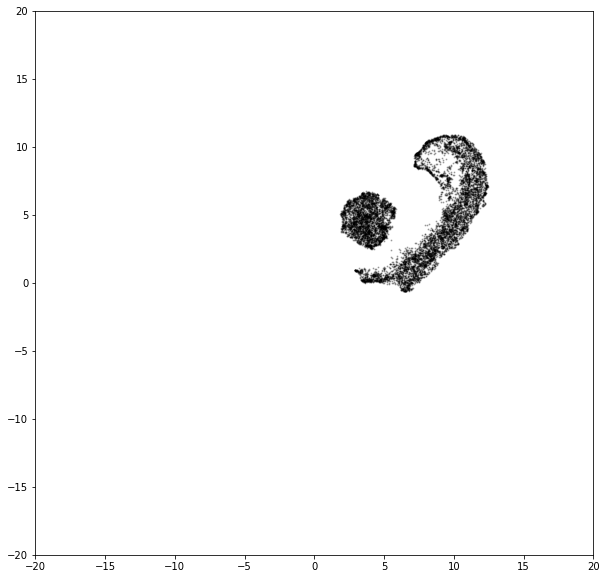

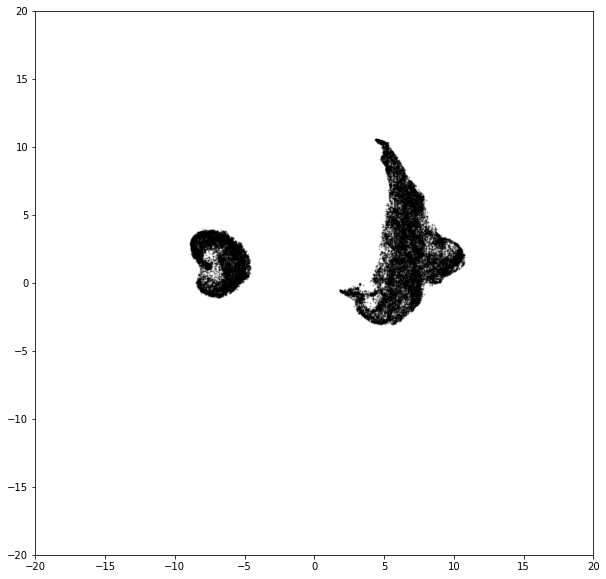

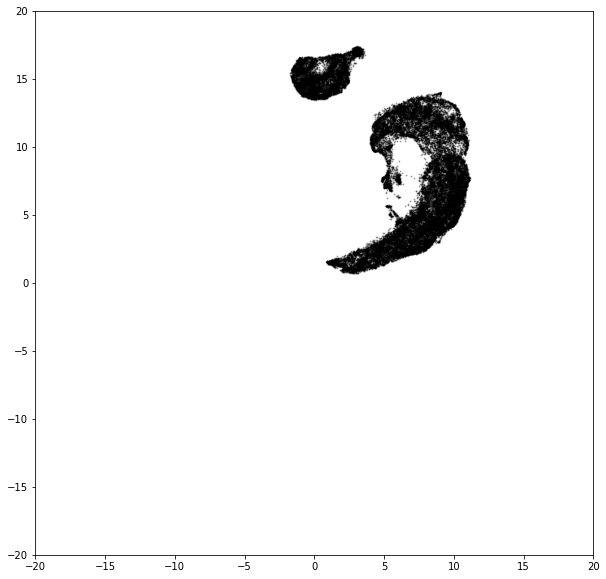

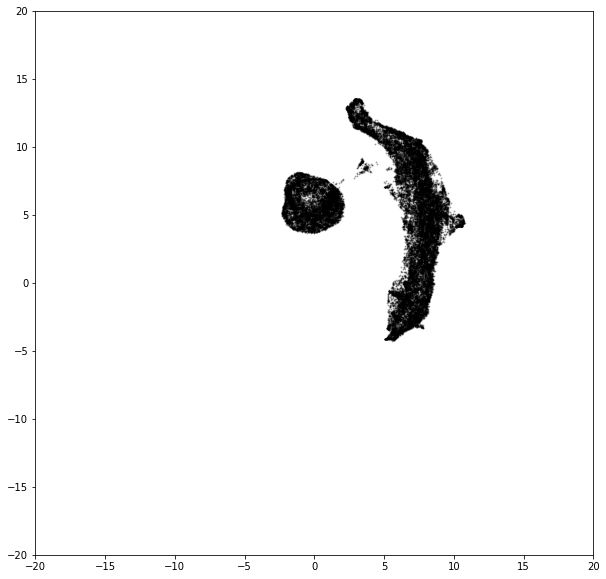

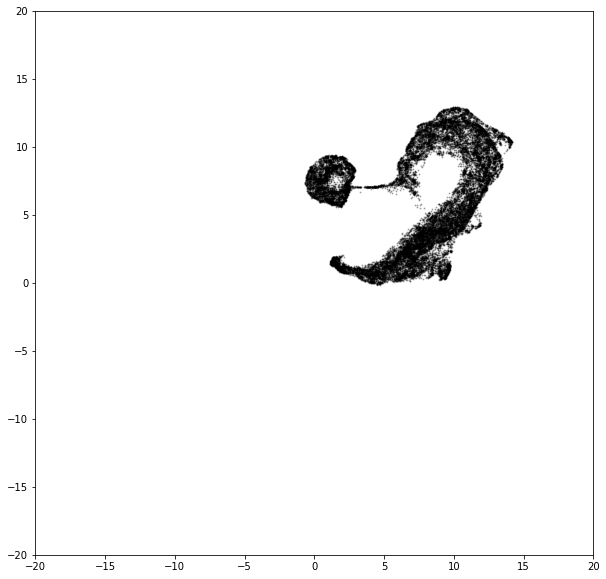

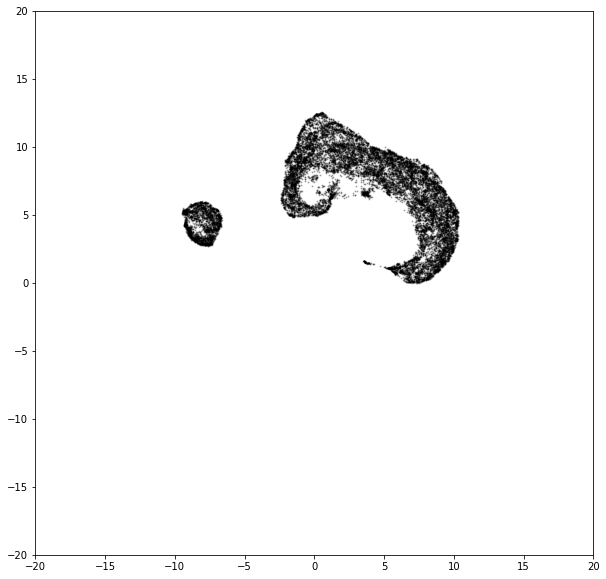

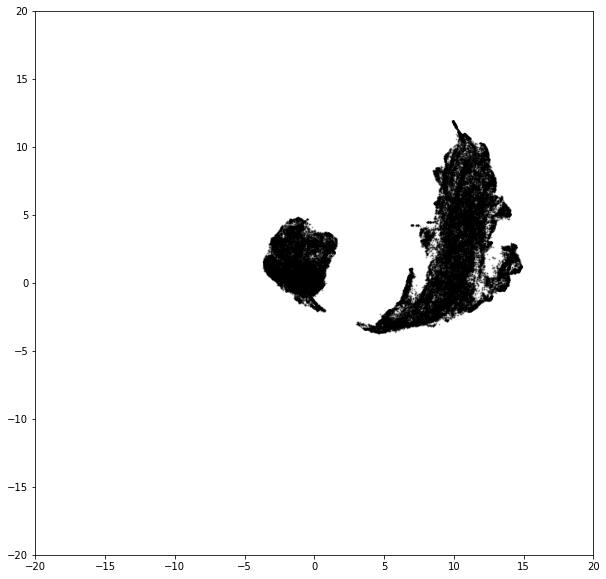

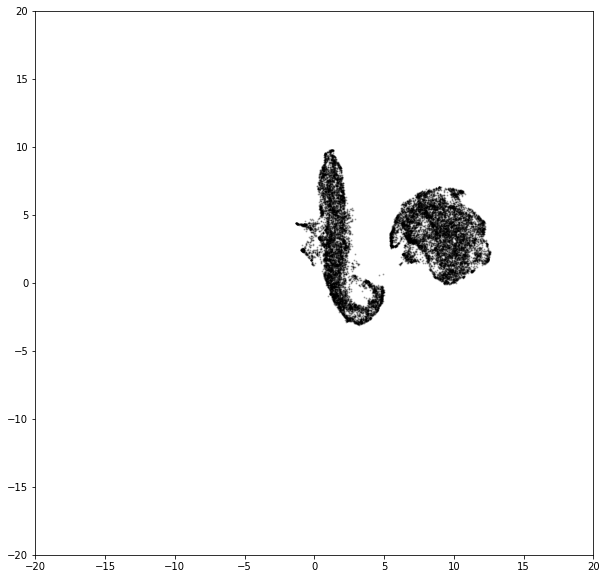

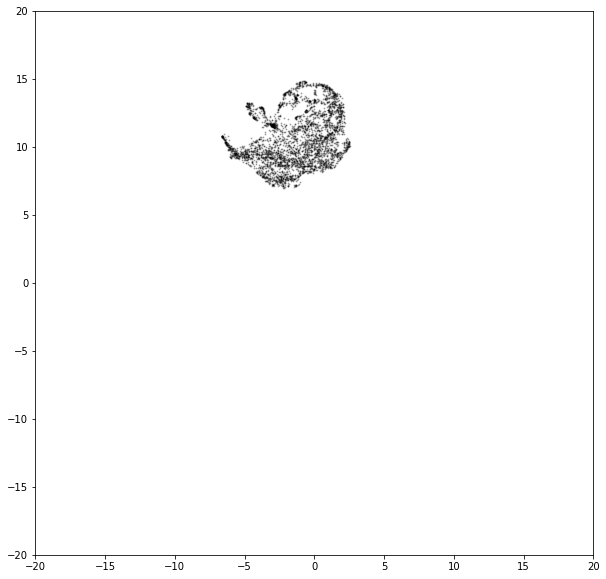

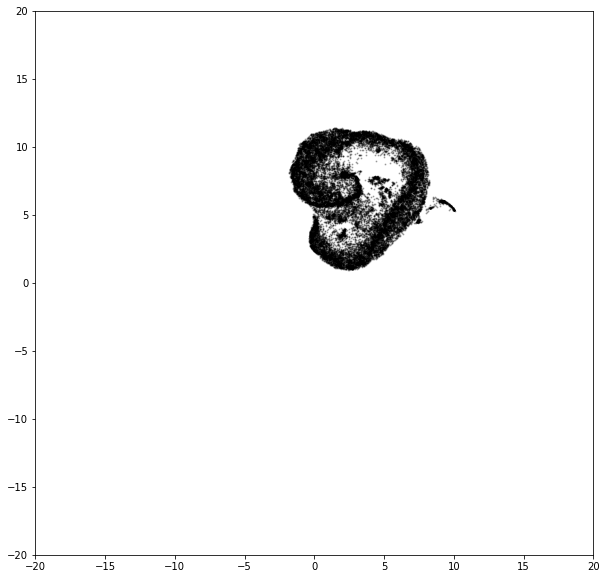

In [100]:
# old
# #species to find embeddings for
# species_list = ['PO','BW', 'BK', 'NB', 'SW', 'LO', 'GO', 'LL', 'IS', 'MU']

# for s in species_list:
  
#     param_name = ('_').join(s+'spec_params_'+iteration)
#     species_clips_dir = os.path.join(clips_root, dataset, 'vocalization_clips', s)
#     max_dur = float(np.max(seg_df['duration'].loc[seg_df['species'] == s]))
    
#     #save spec params
#     if '00_params' not in os.listdir(specs_dir):
#         os.mkdir(specs_dir+'00_params')
#     if param_name not in os.listdir(specs_dir+'00_params'):
#         pd.DataFrame.from_dict(data=spec_params, orient='index').to_csv(specs_dir + '00_params/'+param_name, header=False)
#     else:
#         print('params already exist for', s)

#     wavs_to_umap(clips_dir=species_clips_dir, 
#                  noise_floors_path = spec_params['noise_floors_path'],
#                  species = s, 
#                  noise_floor = None, 
#                  spec_params = spec_params, 
#                  num_to_process = 'all', 
#                  filtered_clips = None, 
#                  interpolate = spec_params['interpolate'], 
#                  segmenting_option=segmenting_option, 
#                  version=iteration)